#### Following [full3D_tutorial.ipynb](https://github.com/hdrake/xwmt/blob/main/examples/full3D_tutorial.ipynb) 

In [1]:
import xarray as xr
import numpy as np

In [2]:
import xwmb
import xwmt
import xgcm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.0.1', '0.0.3', '0.8.2.dev15+g7492277')

In [5]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})

In [6]:
snap = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2_snap.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})

In [7]:
static = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.static.nc", chunks={"xh":360, "yh":270}) #chunks={'time':1})

In [8]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])

In [9]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(static["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(static["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(static["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(static["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(static["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(static["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(rho2_l=0)
ds['sos'] = ds['so'].isel(rho2_l=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [14]:
wm = xwmt.WaterMass(grid)

In [15]:
ds

<xarray.Dataset>
Dimensions:                         (time: 59, rho2_l: 74, yh: 1080, xh: 1440,
                                     nv: 2, rho2_i: 75, yq: 1080,
                                     time_bounds: 60, xq: 1440)
Coordinates: (12/17)
  * nv                              (nv) float64 1.0 2.0
  * rho2_i                          (rho2_i) float64 997.0 ... 1.039e+03
  * rho2_l                          (rho2_l) float64 1.004e+03 ... 1.038e+03
  * time                            (time) object 0186-02-15 00:00:00 ... 019...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
    ...                              ...
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
    deptho                          (yh, xh) float32 nan nan nan ... nan nan nan
    geolon                          (yh, xh) float32 -299.7 -299.5 ... 60.0 60.0
    geolat                          (yh, xh) float32 -79.81 -79.81 ... 64.11
    geolon_c                        (yq, xq) float32 -299.6 -299.4 ... -300.0
    geolat_c                        (yq, xq) float32 -79.77 -79.77 ... 64.06
Data variables: (12/36)
    S_advection_xy                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    ...                              ...
    so_bounds                       (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thetao_bounds                   (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    volcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
    sos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
Attributes:
    filename:            ocean_month_rho2.018601-019012.S_advection_xy.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [16]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

(10.0, 38.0)

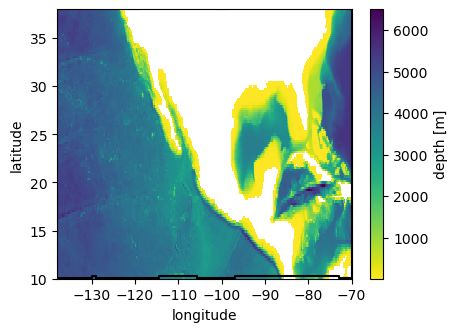

In [18]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

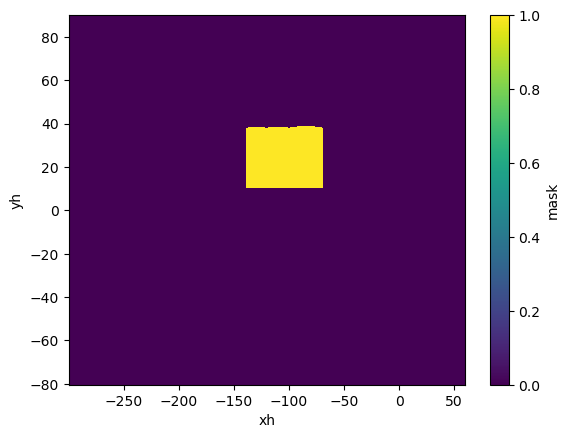

In [19]:
manso_region.mask.plot()

In [43]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        manso_region.mask,
        assert_zero_transport=True
    )
    wmb.mass_budget(lam, greater_than=29, default_bins=True)
    #wmb.wmt.load()
    wmt = wmb.wmt

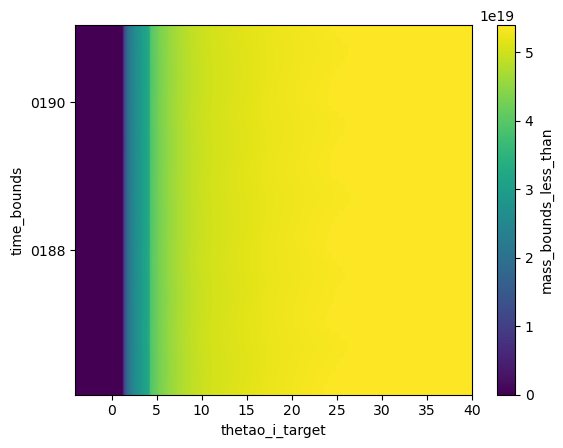

In [45]:
wmb.grid._ds['mass_bounds_less_than'].compute().plot()

In [37]:
wmb.wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/20)
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Eulerian_tendency                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    bottom_flux                                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    mass_source                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    overturning                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Leibniz_material_derivative                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    spurious_numerical_mixing                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>

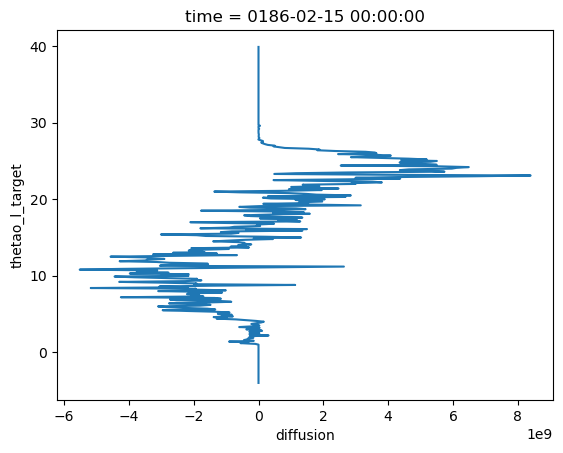

In [48]:
wmt.diffusion.isel(time=0).compute().plot(y="thetao_l_target")

In [24]:
diff = wmt.diffusion.isel(time=0).compute()

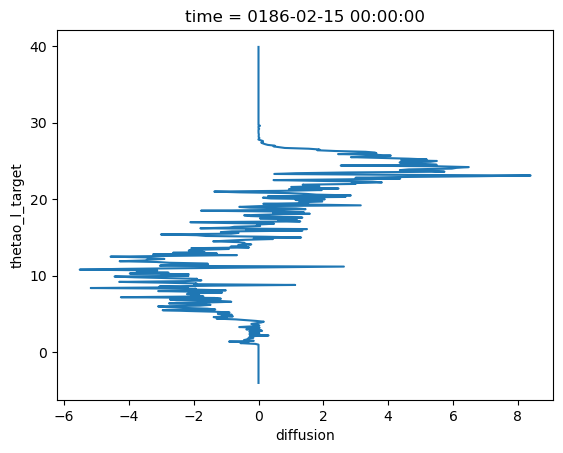

In [25]:
(diff*1e-9).plot(y="thetao_l_target")
#plt.xlim(-0.3, 0.3)
#plt.ylim(0, 20)

In [ ]:
diffusion = wmt['diffusion'].mean('time').compute()

In [19]:
grid._ds

<xarray.Dataset>
Dimensions:                                                         (time: 59,
                                                                     rho2_l: 74,
                                                                     yh: 1080,
                                                                     xh: 1440,
                                                                     nv: 2,
                                                                     rho2_i: 75,
                                                                     yq: 1080,
                                                                     time_bounds: 60,
                                                                     xq: 1440,
                                                                     thetao_l_target: 440,
                                                                     thetao_i_target: 441)
Coordinates: (12/19)
  * nv                                                              (nv) float64 ...
  * rho2_i                                                          (rho2_i) float64 ...
  * rho2_l                                                          (rho2_l) float64 ...
  * time                                                            (time) object ...
  * xh                                                              (xh) float64 ...
  * yh                                                              (yh) float64 ...
    ...                                                              ...
    geolon                                                          (yh, xh) float32 ...
    geolat                                                          (yh, xh) float32 ...
    geolon_c                                                        (yq, xq) float32 ...
    geolat_c                                                        (yq, xq) float32 ...
  * thetao_l_target                                                 (thetao_l_target) float64 ...
  * thetao_i_target                                                 (thetao_i_target) float64 ...
Data variables: (12/81)
    S_advection_xy                                                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                                                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                                                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                                                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                                                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap                                          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    ...                                                              ...
    mass_density_bounds_less_than                                   (time_bounds, yh, xh, thetao_i_target) float32 dask.array<chunksize=(1, 270, 360, 441), meta=np.ndarray>
    mass_bounds_less_than                                           (time_bounds, thetao_i_target) float32 dask.array<chunksize=(1, 441), meta=np.ndarray>
    mass_source_density                                             (time, yh, xh, thetao_l_target) float32 dask.array<chunksize=(1, 270, 360, 440), meta=np.ndarray>
    mass_source_density_less_than                                   (time, yh, xh, thetao_i_target) float32 dask.array<chunksize=(1, 270, 360, 441), meta=np.ndarray>
    mass_source_less_than                                           (time, thetao_i_target) float32 dask.array<chunksize=(1, 441), meta=np.ndarray>
    mass_density                                                    (time, yh, xh, thetao_l_target) float32 dask.array<chunksize=(1, 270, 360, 440), meta=np.ndarray>
Attributes:
   

In [20]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/20)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    mass_source                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    overturning                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Leibniz_material_derivative                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    spurious_numerical_mixing                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>

In [21]:
advection = (wmt['advection']*1e-8).isel(time=0).compute()

In [ ]:
advection_mean = (wmt['advection']*1e-8).mean('time').compute()

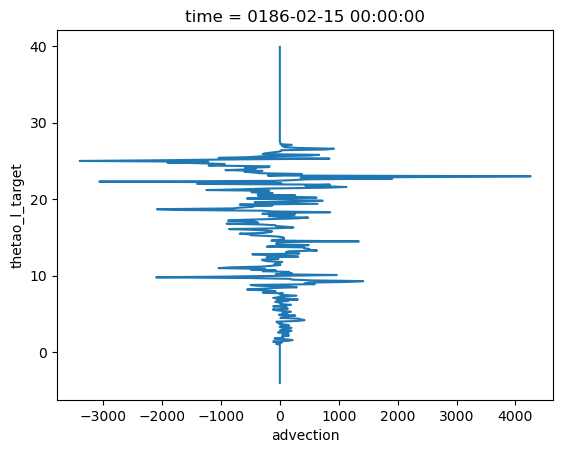

In [22]:
(advection).plot(y="thetao_l_target")

In [ ]:
-wmt['mass_tendency'].isel(time=(0)).isel(thetao_l_target=slice(0,2)).compute()

In [21]:
wmt['mass_tendency']

<xarray.DataArray 'mass_tendency' (time: 59, thetao_l_target: 440)>
dask.array<transpose, shape=(59, 440), dtype=float64, chunksize=(1, 440), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) object 0186-02-15 00:00:00 ... 0190-12-16 12:00:00
  * thetao_l_target  (thetao_l_target) float64 -4.0 -3.9 -3.8 ... 39.7 39.8 39.9

In [24]:
mass_tendency = (-wmt['mass_tendency']*1e-8).isel(time = 0).compute()

In [27]:
mass_tendency_mean = (-wmt['mass_tendency']*1e-8).mean('time').compute()

In [28]:
mass_tendency_mean

<xarray.DataArray 'mass_tendency' (thetao_l_target: 440)>
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.00858411e-05,  6.10014752e-05,  1.20857683e-04,  2.32199779e-04,
        2.94240335e-04,  3.22799842e-04,  3.47498502e-04,  3.71279836e-04,
        4.19404863e-04,  4.49612581e-04,  6.01767980e-04,  1.06035384e-03,
        1.67975799e-03,  1.98844855e-03,  1.97464609e-03,  3.72894440e+00,
        6.30460662e+00,  3.82941252e+00,  1.71522020e+00, -4.65759909e-01,
       -1.89321995e+00, -2.03818503e+00, -2.61098616e+00, -3.24838921e+00,
       -2.51744557e+00, -1.21334297e+00, -8.75626925e-01, -1.01973123e+00,
       -1.11327513e+00, -1.16491316e+00, -1.26922642e+00, -1.35094288e+00,
       -1.36425698e+00, -1.37907065e+00, -1.42886353e+00, -1.58573359e+00,
       -1.89153285e+00, -2.26744958e+00, -2.72899952e+00, -3.26991981e+00,
       -3.79155770e+00, -4.11532997e+00, -4.03358999e+00, -3.71084498e+00,
...
       -2.42111805e-02, -2.36360017e-02, -2.31489553e-02, -2.27500410e-02,
       -2.24346204e-02, -2.21748623e-02, -2.19800437e-02, -2.18316105e-02,
       -2.16785387e-02, -2.15347440e-02, -2.14419733e-02, -2.13631181e-02,
       -2.12981786e-02, -2.12703474e-02, -2.12378776e-02, -2.12007693e-02,
       -2.11822151e-02, -2.11822151e-02, -2.11868537e-02, -2.11868537e-02,
       -2.11914922e-02, -2.12054078e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02,
       -2.12146849e-02, -2.12146849e-02, -2.12146849e-02, -2.12146849e-02])
Coordinates:
  * thetao_l_target  (thetao_l_target) float64 -4.0 -3.9 -3.8 ... 39.7 39.8 39.9

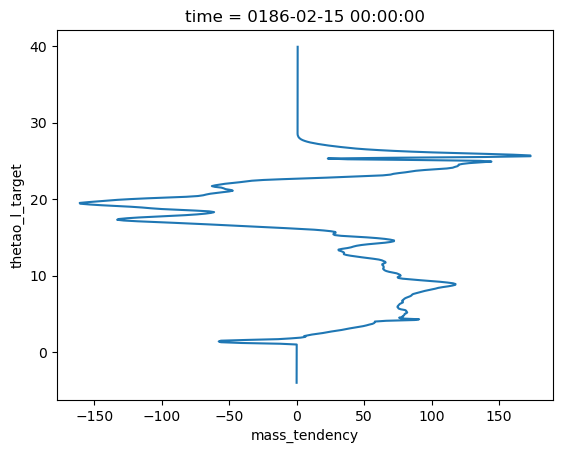

In [55]:
mass_tendency.plot(y="thetao_l_target")

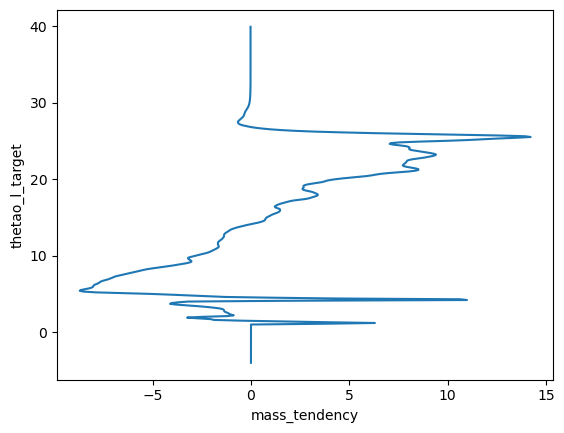

In [29]:
mass_tendency_mean.plot(y="thetao_l_target")

In [33]:
mass_source_mean = (wmt['mass_source']*1e-8).mean('time').compute()
mass_source_mean

<xarray.DataArray 'mass_source' (thetao_l_target: 440)>
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.32126376e-06,  6.83336475e-06,  1.56308270e-05,
        3.36231606e-05,  4.85808923e-05,  5.35198305e-05,  5.81280729e-05,
        6.73912364e-05,  7.51833795e-05,  8.53102101e-05,  9.39189704e-05,
        1.04407321e-04,  1.18420539e-04,  1.23920981e-04,  1.41448574e-04,
        1.77485897e-04,  2.07818171e-04,  2.24107396e-04,  2.43322094e-04,
        2.69353768e-04,  2.91216740e-04,  3.18294624e-04,  3.41355364e-04,
        3.59234051e-04,  3.87088920e-04,  4.34307294e-04,  5.09558828e-04,
        6.03069086e-04,  6.92610454e-04,  7.55213143e-04,  8.08049459e-04,
        8.94369732e-04,  1.00358413e-03,  1.11233001e-03,  1.25698687e-03,
...
       -1.58316445e+00, -1.58317387e+00, -1.58317769e+00, -1.58317983e+00,
       -1.58318579e+00, -1.58319068e+00, -1.58319139e+00, -1.58319199e+00,
       -1.58319259e+00, -1.58319521e+00, -1.58319736e+00, -1.58319747e+00,
       -1.58319747e+00, -1.58319759e+00, -1.58319771e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00,
       -1.58319807e+00, -1.58319807e+00, -1.58319807e+00, -1.58319807e+00],
      dtype=float32)
Coordinates:
  * thetao_l_target  (thetao_l_target) float64 -4.0 -3.9 -3.8 ... 39.7 39.8 39.9

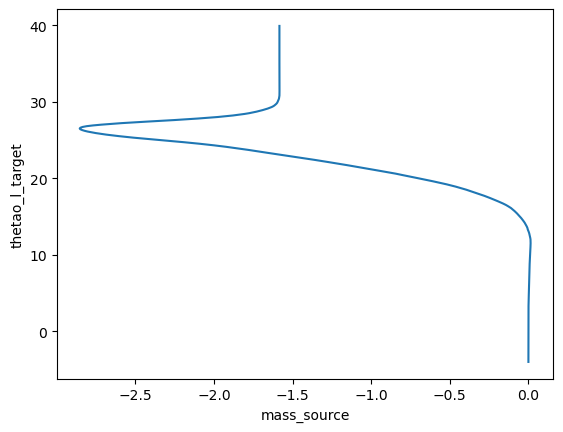

In [37]:
mass_source_mean.plot(y="thetao_l_target")

In [34]:
overturning_mean = (wmt['overturning']*1e-8).mean('time').compute()
overturning_mean

<xarray.DataArray 'overturning' (thetao_l_target: 440)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
  * thetao_l_target  (thetao_l_target) float64 -4.0 -3.9 -3.8 ... 39.7 39.8 39.9

In [39]:
wmb.grid._ds['mass_bounds_less_than'].compute()

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/20)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    mass_source                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    overturning                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Leibniz_material_derivative                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    spurious_numerical_mixing                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>

In [28]:
mass_bounds_less_than_compute = wmb.grid._ds['mass_bounds_less_than'].compute()

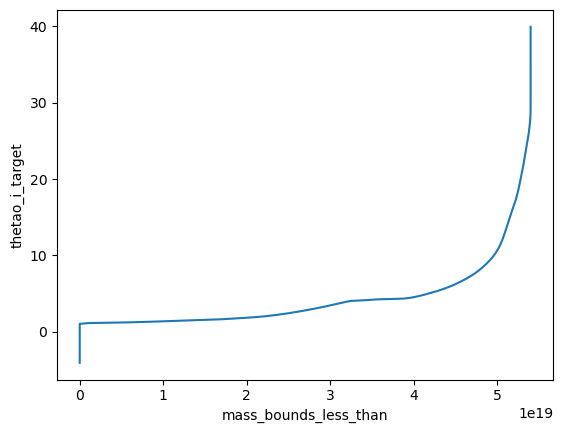

In [30]:
mass_bounds_less_than_compute.mean('time_bounds').plot(y="thetao_i_target")

In [ ]:
wmt['mass_bounds_less_than'] = mass_bounds_less_than_compute

In [60]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/21)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    overturning                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Leibniz_material_derivative                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    spurious_numerical_mixing                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    mass_bounds_less_than                      (time_bounds, thetao_i_target) float32 ...

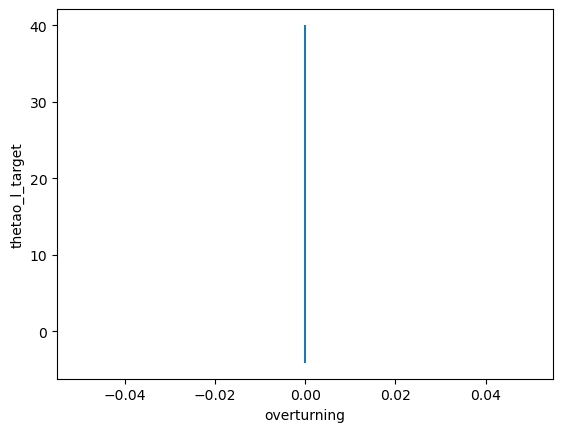

In [38]:
overturning_mean.plot(y="thetao_l_target")

In [61]:
# Save everything into my wmt ds

wmt['mass_tendency_mean'] = mass_tendency_mean
wmt['mass_source_mean'] = mass_source_mean
wmt['overturning_mean'] = overturning_mean

In [62]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/24)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    mass_bounds_less_than                      (time_bounds, thetao_i_target) float32 ...
    mass_tendency_mean                         (thetao_l_target) float64 0.0 ...
    mass_source_mean                           (thetao_l_target) float32 0.0 ...
    overturning_mean                           (thetao_l_target) float32 0.0 ...

In [ ]:
plt.figure(figsize=(15,3.5))

plt.subplot(1,4,1)
(-wmt['mass_tendency']*1e-8).isel(time=0).plot(y="thetao_l_target", label=r"$-\partial_{t} \mathcal{M}$", color="C0")
(wmt['mass_source']*1e-8).isel(time=0).plot(y="thetao_l_target", label=r"$\mathcal{S}$", color="C1")
(wmt['overturning']*1e-8).isel(time=0).plot(y="thetao_l_target", label=r"$\Psi$", color="C2")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.xlabel(r"WMT [$10^{8}$ kg/s]");
plt.ylabel(r"potential temperature [$\degree$C]")
plt.title("a)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

In [67]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/24)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    mass_bounds_less_than                      (time_bounds, thetao_i_target) float32 ...
    mass_tendency_mean                         (thetao_l_target) float64 0.0 ...
    mass_source_mean                           (thetao_l_target) float32 0.0 ...
    overturning_mean                           (thetao_l_target) float32 0.0 ...

In [ ]:
wmt.to_netcdf('WMT_analysis/wmt.nc', mode = 'w')

In [ ]:
#z_section = wm.grid._ds['z'].isel(time=0,yh=500).compute()

In [34]:
temp = wm.grid._ds['thetao'].isel(time =0, yh =500).compute()

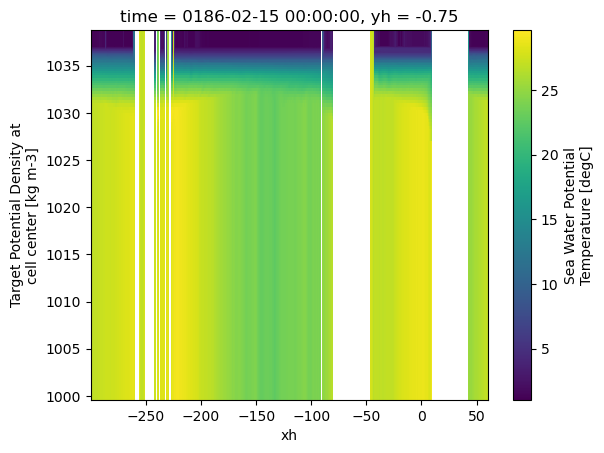

In [36]:
temp.plot()

In [40]:
import matplotlib.pyplot as plt

thetao0 = 1.

In [ ]:
plt.figure(figsize=(15,3.5))

plt.subplot(1,4,1)
(-wmt['mass_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$-\partial_{t} \mathcal{M}$", color="C0")
(wmt['mass_source']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{S}$", color="C1")
(wmt['overturning']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\Psi$", color="C2")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.xlabel(r"WMT [$10^{8}$ kg/s]");
plt.ylabel(r"potential temperature [$\degree$C]")
plt.title("a)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,2)
(wmt['Eulerian_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Tend)}$", color="C0")
(wmt['diabatic_advection']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Dia)}$", color="C1")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]");
plt.title("b)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,3)
(wmt['boundary_fluxes'].mean('time')*1e-8).plot(y="thetao_l_target", label=r"$\mathcal{G}^{(BC)}$", color="C0")
(wmt['diffusion']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Mix)}$", color="C1")
(wmt['spurious_numerical_mixing']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Num)}$", color="C2")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]")
plt.title("c)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,4)
label = r"$-\partial_{t} \mathcal{M} + \mathcal{S} + \Psi$"
((-wmt['mass_tendency'] + wmt['mass_source'] + wmt['overturning'])*1e-8).mean('time').plot(y="thetao_l_target", label=label)
label = r"$\mathcal{G}^{(Tend)} + \mathcal{G}^{(Dia)}$"
((wmt['Eulerian_tendency'] + wmt['diabatic_advection'])*1e-8).mean('time').plot(y="thetao_l_target", label=label, ls="--")
label= r"$\mathcal{G}^{(BC)} + \mathcal{G}^{(Mix)} + \mathcal{G}^{(Num)}$"
((wmt['boundary_fluxes'] + wmt['diffusion'] + wmt['spurious_numerical_mixing'])*1e-8).mean('time').plot(y="thetao_l_target", label=label, ls=":")
plt.grid(True, alpha=0.4)
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.title("d)", loc="left", y=0.91, x=0.02)
plt.xlabel(r"WMT [$10^{8}$ kg/s]");


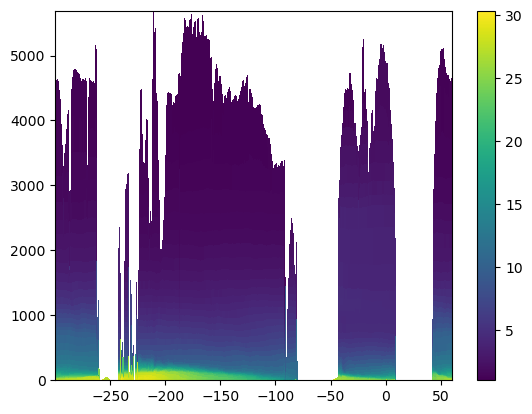

In [24]:
import matplotlib.pyplot as plt

plt.pcolor(
    z_section.xh*xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose()
)
plt.colorbar()

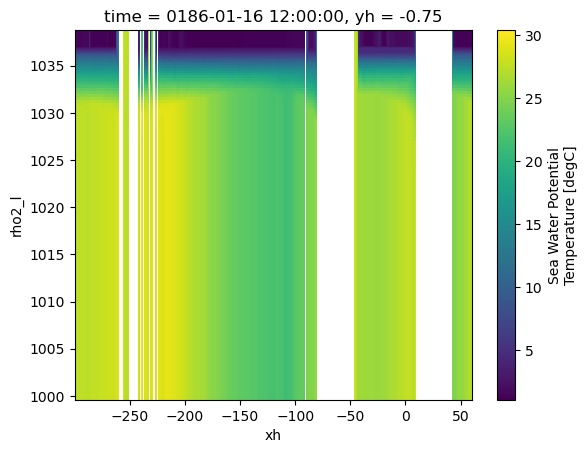

In [25]:
wm.get_density()
temp = wm.grid._ds['thetao'].isel(time =0, yh =500).plot()

In [42]:
wm.grid._ds

<xarray.Dataset>
Dimensions:                         (time: 60, rho2_l: 74, yh: 1080, xh: 1440,
                                     nv: 2, rho2_i: 75, yq: 1080, xq: 1440)
Coordinates: (12/13)
  * nv                              (nv) float64 1.0 2.0
  * rho2_i                          (rho2_i) float64 997.0 ... 1.039e+03
  * rho2_l                          (rho2_l) float64 1.004e+03 ... 1.038e+03
  * time                            (time) object 0186-01-16 12:00:00 ... 019...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
    ...                              ...
    lon                             (yh, xh) float32 -299.7 -299.5 ... 60.0 60.0
    lat                             (yh, xh) float32 -79.81 -79.81 ... 64.11
  * xq                              (xq) float64 -299.6 -299.3 ... 59.91 60.16
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
    geolon_c                        (yq, xq) float32 -299.6 -299.4 ... -300.0
    geolat_c                        (yq, xq) float32 -79.77 -79.77 ... 64.06
Data variables: (12/30)
    S_advection_xy                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    ...                              ...
    thkcello                        (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    vert_remap_h_tendency           (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    vhml                            (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    vmo                             (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    volcello                        (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 1080, 1440), meta=np.ndarray>
    thkcello_i                      (time, yh, xh, rho2_i) float32 dask.array<chunksize=(1, 1080, 1440, 75), meta=np.ndarray>
Attributes:
    filename:            ocean_month_rho2.018601-019012.S_advection_xy.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [ ]:
tmp = w.get_outcrop_lev(incrop=True)

In [37]:
snap

<xarray.Dataset>
Dimensions:    (time: 60, zl: 75, yh: 1080, xh: 1440, yq: 1080, xq: 1440)
Coordinates:
  * time       (time) object 0186-02-01 00:00:00 ... 0191-01-01 00:00:00
  * xh         (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh         (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * zl         (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
    areacello  (yh, xh) float32 3.439e+07 3.437e+07 ... 2.097e+06 9.053e+05
    lon        (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    lat        (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
    geolon_c   (yq, xq) float32 -299.6 -299.4 -299.1 ... -300.0 -300.0 -300.0
    xy         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
    geolat_c   (yq, xq) float32 -79.77 -79.77 -79.77 ... 64.28 64.17 64.06
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    rhopot2    (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 1080, 1440), meta=np.ndarray>
    volcello   (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 1080, 1440), meta=np.ndarray>
    zos        (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    thkcello   (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:            ocean_monthly_snap.018601-019012.rhopot2.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [78]:
xr.open_dataset("WMT_analysis/wmt.nc") #chunks={'time':100})

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/24)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 ...
    frazil_ice                                 (time, thetao_l_target) float64 ...
    advection                                  (time, thetao_l_target) float64 ...
    surface_exchange_flux                      (time, thetao_l_target) float64 ...
    diffusion                                  (time, thetao_l_target) float64 ...
    ...                                         ...
    advection_plus_BC                          (time, thetao_l_target) float64 ...
    diabatic_advection                         (time, thetao_l_target) float64 ...
    mass_bounds_less_than                      (time_bounds, thetao_i_target) float32 ...
    mass_tendency_mean                         (thetao_l_target) float64 ...
    mass_source_mean                           (thetao_l_target) float32 ...
    overturning_mean                           (thetao_l_target) float32 ...